In [2]:
import pandas as pd
import numpy as np
from classes.TrainDataset import TrainDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import torch.nn as nn
%matplotlib inline

## Plan:
- Use a pre-trained model for feature extraction
- Make pre-trained/homemade model for feature processing
- Compute 20*20 sine/cosine similarity matrix
- Select top 2 images most similar to 'left' image

### Preprocess and show

In [3]:
# Import train and test data
test_candidates = pd.read_csv('data/test_candidates.csv')
train_candidates = pd.read_csv('data/train_candidates.csv')
train_true = pd.read_csv('data/train.csv')
train_true.head()

,left,right
0,aaa,osr
1,aaz,mqw
2,abh,cdx
3,abn,uzp
4,abq,bbd


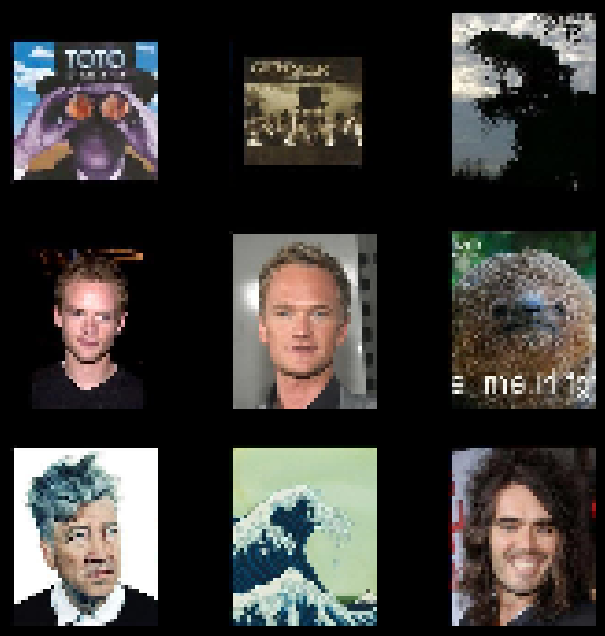

In [5]:
# Visualize Pair of matching images + a rdm image


def preprocess_image(image):
    """Original images are 200x245, normalize and downsample image to 40x49"""
    image = image.astype(np.float32) / 255.
    return image[::5, ::5]

def show(ax, fig, image_path, with_preprocess=True):
    img = mpimg.imread(image_path)
    if with_preprocess:
        img = preprocess_image(img)
    ax.imshow(img)
    ax.axis('off')

fig, axs = plt.subplots(3, 3, figsize=(8, 8), facecolor='black')

for i in range(3):
    left, right = train_true.iloc[i]
    # Pair of matching images
    show(axs[i, 0], fig, 'data/train/all/{}.jpg'.format(left))
    show(axs[i, 1], fig, 'data/train/all/{}.jpg'.format(right))
    # random image from the train set (not a true match)
    rd_img = random.sample(list(train_candidates.iloc[i].where(lambda x: ~x.isin([left, right])).dropna()), 1)[0]
    show(axs[i, 2], fig, 'data/train/all/{}.jpg'.format(rd_img))

### Cosine similarity

In [61]:
# compute cosine similartiy matrix between first image of train_candidates
# and all 20 images of the same row
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(row, with_preprocessing=True):
    """Compute cosine similarity between first image of row and all other images in row"""
    left = row.iloc[0]
    right = row.iloc[1:]
    
    # Using downsampled 40x49 images gives a very close cosine similarity to the original 200x245 images
    if with_preprocessing:
        left = preprocess_image(mpimg.imread('train/all/{}.jpg'.format(left))).flatten()
        right = [preprocess_image(mpimg.imread('train/all/{}.jpg'.format(img))).flatten() for img in right]
    else: 
        left = mpimg.imread('train/all/{}.jpg'.format(left)).flatten()
        right = [mpimg.imread('train/all/{}.jpg'.format(img)).flatten() for img in right]

    left = left.reshape(1, -1)
    right = np.array(right)
    return left, right, cosine_similarity(left, right)[0]


In [62]:
left, right, sim_matrix = compute_cosine_similarity(train_candidates.loc[0])
pred_ind = np.argmax(sim_matrix)
true_row_ind = row_idx = (train_candidates.iloc[0] == train_true.iloc[0, 1]).idxmax()
true_col_idx = list(train_candidates.columns).index(true_row_ind)
print('base img:', train_candidates.loc[0, 'left'], '/ pred:', train_candidates.loc[0, train_candidates.columns[pred_ind]], "/ dist = ", sim_matrix[pred_ind])
print('base img:', train_candidates.loc[0, 'left'], '/ true:', train_candidates.loc[0, train_candidates.columns[true_col_idx]], "/ dist = ", sim_matrix[true_col_idx])

base img: aaa / pred: vrg / dist =  0.7577027
base img: aaa / true: osr / dist =  0.3814749


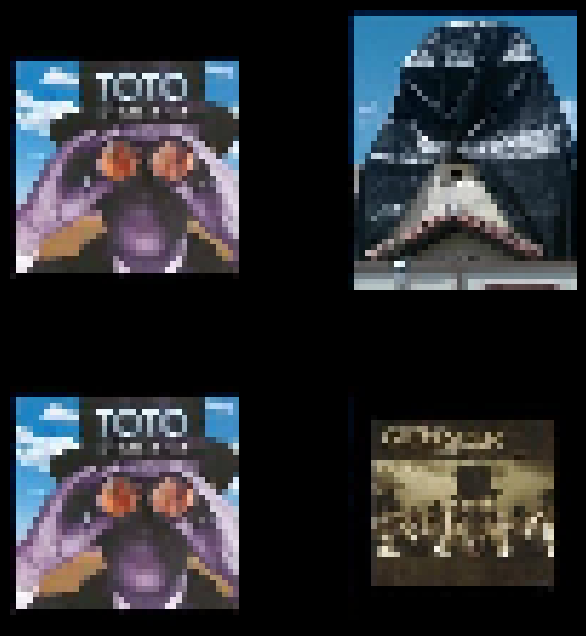

In [63]:
# Show image aaa and its most similar image
fig, axs = plt.subplots(2, 2, figsize=(8, 8), facecolor='black')
show(axs[0, 0], fig, 'train/all/{}.jpg'.format("aaa"))
show(axs[0, 1], fig, 'train/all/{}.jpg'.format(train_candidates.loc[0, train_candidates.columns[pred_ind]]))
show(axs[1, 0], fig, 'train/all/{}.jpg'.format("aaa"))
show(axs[1, 1], fig, 'train/all/{}.jpg'.format(train_candidates.loc[0, train_candidates.columns[true_col_idx]]))

### clip res50x4, eval with 640 encoding

In [3]:
train_folder = 'data/train/'
test_folder = 'data/test/'
csv_folder = 'data/'

train_csv = csv_folder + 'train.csv'
train_candidates_csv = csv_folder + 'train_candidates.csv'
test_candidates_csv = csv_folder + 'test_candidates.csv'

In [4]:
from clip import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model, transform = clip.load("RN50x4", device)

cpu


In [4]:
train_dataset = TrainDataset(train_csv, train_candidates_csv, train_folder+'left', train_folder+'all', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [5]:
import torchvision.transforms as transforms

# import image 'train/all/aaa.jpg' and preprocess it
img = mpimg.imread('data/train/all/aaa.jpg')
# convert to tensor with torch
t = transforms.Compose([transforms.ToPILImage(), 
                        transform, 
                        # add batch dimension
                        transforms.Lambda(lambda x: x.unsqueeze(0))])

print(img.shape)
img_t = t(img)
img_vis = model.visual(img_t).detach().numpy().flatten()
img_enc = model.encode_image(img_t).detach().numpy().flatten()
print(img_vis.shape, img_enc.shape)

(245, 200, 3)
(640,) (640,)


In [83]:
# Get number of files in data/train/all
import os
print(len(os.listdir('data/train/all')))

4000


In [143]:
# Make PCA on training data
from sklearn.decomposition import PCA
import glob
import time

def apply_model_on_all_images(model, transform):
    """Make PCA on all images in data/train/all"""
    images = []
    start_time = time.time()
    # for i, data in enumerate(loader):
    #     # =============================================
    #     left, candidates, label = data
    #     cand_enc = [model(cand).detach().numpy().flatten() for cand in candidates]
    #     images += cand_enc
    #     # =============================================

    # One by one with blob
    count = 0
    for img_path in glob.glob('data/test/all/*.jpg'):
        img = mpimg.imread(img_path)
        img_t = transform(img)
        img_enc = model(img_t).detach().numpy().flatten()
        images.append(img_enc)

        if count%200 == 0:
            print(f"Processed: {count}, Elapsed time: ", time.time() - start_time)
            start_time = time.time()
            
        count += 1
    return images

images = apply_model_on_all_images(model.visual, t)
images_np = np.array(images)
np.save('data/test_all_encodings.npy', images_np)

Processed: 200, Elapsed time:  60.14198303222656
Processed: 400, Elapsed time:  60.27185344696045
Processed: 600, Elapsed time:  58.58591365814209
Processed: 800, Elapsed time:  65.66582989692688
Processed: 1000, Elapsed time:  67.36906027793884
Processed: 1200, Elapsed time:  62.32206630706787
Processed: 1400, Elapsed time:  59.20091533660889
Processed: 1600, Elapsed time:  57.49395751953125
Processed: 1800, Elapsed time:  57.465863943099976
Processed: 2000, Elapsed time:  57.311431646347046
Processed: 2200, Elapsed time:  58.51872682571411
Processed: 2400, Elapsed time:  57.45001459121704
Processed: 2600, Elapsed time:  57.49142336845398
Processed: 2800, Elapsed time:  56.947744369506836
Processed: 3000, Elapsed time:  57.07139611244202
Processed: 3200, Elapsed time:  57.03157567977905
Processed: 3400, Elapsed time:  56.04728031158447
Processed: 3600, Elapsed time:  54.594292879104614
Processed: 3800, Elapsed time:  54.43100547790527
Processed: 4000, Elapsed time:  52.74608397483826


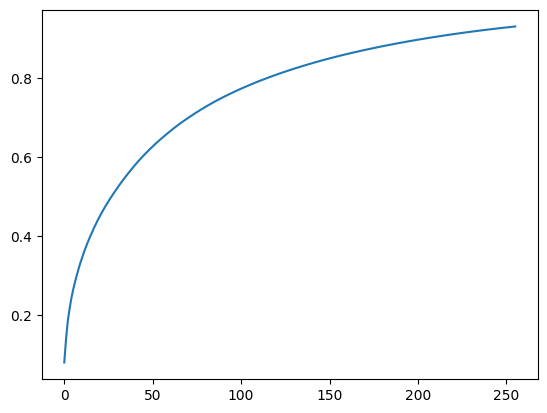

In [81]:
# train pca on the images
pca = PCA(n_components=256)
pca.fit(images_np)
sum(pca.explained_variance_ratio_)
plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))

Cosine similarity on encoded images

In [322]:
from sklearn.metrics.pairwise import cosine_similarity

def cos_sim_np(left, right_images):
    """Compute cosine similarity between first image of row and all other images in row"""
    return np.array([cosine_similarity(left, right_images[i])[0][0] for i in range(len(right_images))])

def cos_sim_enc(images_enc, images_names, candidates_csv):

    results = []
    start_time = time.time()
    for i, row in candidates_csv.iterrows():
        # Compute cosine similarity between left and all other images in row
        left = images_enc[np.where(images_names == row['left'])]
        right_images = np.array([images_enc[np.where(images_names == row[f'c{i}'])] for i in range(20)])
        sim_array = cos_sim_np(left, right_images)
        res = [row['left']] + list(sim_array)
        results.append(list(res))

        if i%400 == 0 and i!=0:
            print(f"Processed: {i}")
            print("Elapsed time: ", time.time() - start_time)
            start_time = time.time()
            
    results = np.array(results)
    column_names = ['left'] + [f'c{i}' for i in range(20)]
    df = pd.DataFrame(results, columns=column_names)

    return df

In [172]:
# Load encoded images
train_images_enc = np.load('data/train_all_encodings.npy')
test_images_enc = np.load('data/test_all_encodings.npy')

# Read candidates
test_candidates = pd.read_csv(test_candidates_csv)
train_candidates = pd.read_csv(train_candidates_csv)

# Get images names
test_images_names = np.array([x.split('.')[0] for x in os.listdir('data/test/all')])
train_images_names = np.array([x.split('.')[0] for x in os.listdir('data/train/all')])

# df_test = cos_sim_enc(test_images_enc, test_images_names, test_candidates)
df_train = cos_sim_enc(train_images_enc, train_images_names, train_candidates)

Processed: 0
Elapsed time:  0.005892753601074219
Processed: 400
Elapsed time:  2.151768207550049
Processed: 800
Elapsed time:  2.1563963890075684
Processed: 1200
Elapsed time:  2.1429543495178223
Processed: 1600
Elapsed time:  2.1392507553100586


In [323]:
# Evaluate result. For each row in df_train get index of colmuns of top 2 values
# and check if the true match is in the top 2

def get_score(row, row_nb, true_labels, candidates):
    """return 1 if true label in top_2, else return 0"""
    # Get top 2
    top_2 = row[1:].argsort()[-2:][::-1].values

    # Get true label
    label_row = true_labels[true_labels['left'] == row['left']]
    true_label = label_row['right'].values[0]

    # Get top 2 predicted labels. i+1 to account for 'left' column
    top_2_names = [candidates.iloc[row_nb, i+1] for i in top_2]
    if true_label in top_2_names:
        return 1
    else:
        return 0

def eval(df, true_labels, candidates):
    """Evaluate score on df"""
    score = 0 
    for i, row in df.iterrows():
        score += get_score(row, i, true_labels, candidates)
    return score/len(df)
    
eval(df_train, train_labels, train_candidates)

0.087

### Extract encoding from layers + PCA 

In [238]:
def get_layer_index(model: nn.Module, layer_name: str):
    """
    Given a model and a layer_name (str), this will return its corresponding index in 
    the list model.modules(). That is given some nn.Module object M that is composed of other nn.Modules
    [m_1, m_2, m_3..., m_n], if we can access these sub_modules like M.sub_module_name, then this
    function will return the corresponding index of this submodule.
    
    [Warning] : This doesn't work for nested submodules !


    Example:
        resnet = torchvision.models.resnet18(pretrained=True).eval()
            ResNet(
                (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                ...
                ...
                (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
                (fc): Linear(in_features=512, out_features=1000, bias=True)
            )

        In [3]: utils.get_layer_index(resnet, 'avgpool')
        Out[3]: 66

    """
    return list(model.modules()).index(getattr(model, layer_name))

In [247]:
layers_names = ["layer1", "layer2", "layer3", "layer4", "attnpool"]

layers_indices = [
    layer if isinstance(layer, int) else get_layer_index(model.visual, layer)
    for layer in layers_names
]

print(layers_indices)

modules = []
for layer_index in layers_indices:
    layer_name, module = list(model.visual.named_modules())[layer_index]
    modules.append(module)
    print(layer_name, module)

[11, 60, 131, 246, 317]
layer1 Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (avgpool): Identity()
    (conv3): Conv2d(80, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (downsample): Sequential(
      (-1): AvgPool2d(kernel_size=1, stride=1, padding=0)
      (0): Conv2d(80, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv

In [282]:
# get first 10 layers of model.visual
pre_modules = []
for layer_index in range(1, 11):
    layer_name, pre_module = list(model.visual.named_modules())[layer_index]
    pre_modules.append(pre_module)
    print(layer_name, pre_module)

conv1 Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
bn1 BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu1 ReLU(inplace=True)
conv2 Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
bn2 BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu2 ReLU(inplace=True)
conv3 Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
bn3 BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu3 ReLU(inplace=True)
avgpool AvgPool2d(kernel_size=2, stride=2, padding=0)


In [307]:
# Make PCA on training data
from sklearn.decomposition import PCA
import glob
import time

def get_full_encoding(folder_path, pre_modules, modules, transform):
    """Get encoding for all images in folder_path"""
    images = []
    start_time = time.time()

    # One by one with blob
    count = 0
    for img_path in glob.glob(f'{folder_path}/*.jpg'):
        # get and preprocess
        img = mpimg.imread(img_path)
        img_t = transform(img)

        # layers for which we're not interested in the output
        out = img_t
        for pre_module in pre_modules:
            out = pre_module(out)

        # layers for which we're interested in the output
        for i in range(len(modules)):
            module = modules[i]
            out = module(out)
            if out.ndim == 4:
                # Average spatial dimensions
                vec = torch.mean(out, dim=(2, 3))
                # L2 normalization
                vec = vec / vec.norm(dim=-1, keepdim=True)
            else:
                vec = out
                vec = vec / vec.norm(dim=-1, keepdim=True)

            # concatenate outputs
            if i == 0:
                img_encoding = vec
            else:
                img_encoding = torch.cat((img_encoding, vec), dim=1)

        # Make numpy array from tensor
        img_enc = img_encoding.detach().numpy().flatten()
        images.append(img_enc)
        count += 1
    
        if count%100 == 0:
            print(f"Processed: {count}, Elapsed time: ", time.time() - start_time)
            start_time = time.time()
    return images

images = get_full_encoding("data/train/all", pre_modules, modules, t)
images_np = np.array(images)
np.save('data/train_all_full_encodings.npy', images_np)

Processed: 100, Elapsed time:  47.787498474121094
Processed: 200, Elapsed time:  48.88569617271423
Processed: 300, Elapsed time:  46.73696422576904
Processed: 400, Elapsed time:  49.71382522583008
Processed: 500, Elapsed time:  46.9507257938385
Processed: 600, Elapsed time:  48.023240089416504
Processed: 700, Elapsed time:  45.24288558959961
Processed: 800, Elapsed time:  44.97662806510925
Processed: 900, Elapsed time:  27.622908115386963
Processed: 1000, Elapsed time:  29.81552815437317
Processed: 1100, Elapsed time:  29.5990252494812
Processed: 1200, Elapsed time:  30.021722555160522
Processed: 1300, Elapsed time:  30.097428798675537
Processed: 1400, Elapsed time:  30.101203680038452
Processed: 1500, Elapsed time:  30.136028051376343
Processed: 1600, Elapsed time:  30.039518117904663
Processed: 1700, Elapsed time:  30.066920280456543
Processed: 1800, Elapsed time:  30.082340717315674
Processed: 1900, Elapsed time:  30.03221893310547
Processed: 2000, Elapsed time:  30.59549617767334
P

In [310]:
# Train PCA
pca = PCA(n_components=256)
pca.fit(images)
images_pca = pca.transform(images)
sum(pca.explained_variance_ratio_)

0.9293111252860856

In [324]:
df_train_pca = cos_sim_enc(images_pca, train_images_names, train_candidates)
eval(df_train_pca, train_labels, train_candidates)

Processed: 400
Elapsed time:  2.101637363433838
Processed: 800
Elapsed time:  2.102018117904663
Processed: 1200
Elapsed time:  2.2149481773376465
Processed: 1600
Elapsed time:  2.1387860774993896


0.66

### Full encoding on test set

In [326]:
images = get_full_encoding("data/test/all", pre_modules, modules, t)
images_np = np.array(images)
np.save('data/test_all_full_encodings.npy', images_np)

Processed: 100, Elapsed time:  34.47717475891113
Processed: 200, Elapsed time:  30.043052673339844
Processed: 300, Elapsed time:  33.169493436813354
Processed: 400, Elapsed time:  28.41561532020569
Processed: 500, Elapsed time:  28.443338871002197
Processed: 600, Elapsed time:  28.27947473526001
Processed: 700, Elapsed time:  28.46919012069702
Processed: 800, Elapsed time:  28.565932035446167
Processed: 900, Elapsed time:  28.415544033050537
Processed: 1000, Elapsed time:  28.39693546295166
Processed: 1100, Elapsed time:  28.609461307525635
Processed: 1200, Elapsed time:  28.975898504257202
Processed: 1300, Elapsed time:  24.44570565223694
Processed: 1400, Elapsed time:  24.672051191329956
Processed: 1500, Elapsed time:  24.594053983688354
Processed: 1600, Elapsed time:  24.95507001876831
Processed: 1700, Elapsed time:  24.447980403900146
Processed: 1800, Elapsed time:  24.46396493911743
Processed: 1900, Elapsed time:  24.436610221862793
Processed: 2000, Elapsed time:  24.4107620716094

In [327]:
# Train PCA
images_test_pca = pca.transform(images)
df_test_pca = cos_sim_enc(images_test_pca, test_images_names, test_candidates)

Processed: 400
Elapsed time:  2.1318752765655518
Processed: 800
Elapsed time:  2.0679540634155273
Processed: 1200
Elapsed time:  2.0587756633758545
Processed: 1600
Elapsed time:  2.0641634464263916


In [334]:
df_test_pca.iloc[:, 1:]

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19
0,-0.12657759333683755,-0.15611861394718946,0.21079052707730114,-0.06977413466335716,-0.11859047738756037,0.10456780540797195,0.08311572690681503,-0.32121682805226026,-0.09240837883052369,0.044253030421659595,-0.09106612420501578,0.2145523212231575,-0.037980879539293216,0.010208661717664713,-0.0006597467961104581,0.09341634628912028,0.04905506978267926,-0.038697083867029594,0.1597076401219554,-0.06854491405547398
1,-0.05373219988377243,0.11308097060686917,-0.1885544391482796,0.055106731124775724,-0.02633725770047278,-0.08438041998676074,-0.05884025329366069,-0.0030821674782970654,-0.06354861622424349,0.4296891264245122,-0.08094769782858417,-0.06454949630755832,0.19333647875502602,0.07096396883852052,-0.07734593046253319,-0.17507763227794193,-0.06558100128566943,-0.22388860516111392,-0.014632287351559366,0.010280088081167836
2,0.12893271195869427,0.5268242071343517,-0.0063411743412433025,0.05566884711996242,0.10826263236363744,-0.10021259330269838,-0.11610331096509968,-0.05477029958016835,0.10814766454198199,-0.1699744392542593,-0.19944944329405795,-0.07469962149966443,0.2931531661220097,0.18656615500041265,0.09055316323278706,0.19234433376462334,-0.27119310508567007,0.04686576309051216,0.18463048037797553,0.29808865073451485
3,-0.09892225516284034,-0.09003706708088716,-0.059950208545180426,-0.14484851225752096,-0.09395801766416871,0.28760774953143536,0.024564194714627036,0.12497966336221095,-0.1262817233715421,0.04324686575884015,-0.010573780463292892,-0.1634433558476882,-0.094669486422665,-0.1340740388478686,-0.027299063081262818,0.13307351076258483,0.10626998173562477,-0.18485412010679136,0.19231466037914388,0.07445439012260774
4,0.2116638035553129,-0.030810676235777587,0.19461997131204026,-0.14683193029634212,0.036572029064607964,-0.027976618524567787,-0.07701174626239421,0.009798618640098983,0.06239130290811988,0.026683983351295466,-0.2342795878397569,-0.010970196068872017,0.06251629771513424,-0.06452202819674166,-0.01627309740061326,-0.14549538365988185,0.0440840427249396,0.22630467737258517,0.10273150480000223,0.0014852969240834457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.2898871378836142,-0.1906435465375122,-0.02013696478919554,-0.08559430256951137,-0.09780907718518106,0.09113345276346012,-0.07838993268096324,-0.07276035496077106,0.028069155226203818,0.027342032812538428,-0.16244216585032456,-0.09243006280731125,-0.1872749340878921,0.021033149066197535,-0.008472810644275346,-0.08747310601582663,0.028083527780636462,-0.05631009979376552,-0.003354703258748634,0.2110941717112868
1996,-0.11015535696616019,-0.1430460642354316,0.21900724440799946,0.03355906273586419,-0.03297618898392922,-0.13601795190551397,-0.08647017831900308,0.09064528443037483,-0.025949973469116153,0.05267282834072748,0.16306819374501935,0.15208679585974785,0.111818644089138,-0.08109506116335152,-0.12938251053626806,0.1891444475816655,0.0027926863759882223,-0.04092643828230978,0.0697241580660311,0.10842027723861512
1997,0.2529673331333204,0.039455827382491954,-0.01732192631867414,0.0392044987986101,-0.11674489534359209,-0.04915856073615295,0.128926080973482,-0.07513387404043523,-0.11028927071885937,0.1682986472142507,-0.18850431513901816,-0.08302753803842242,-0.0009473100440582777,-0.09699126210871442,0.12441662305947045,0.08930235586594074,-0.0598474248970489,0.11354829887669982,-0.1556399354599678,0.209474489680882
1998,-0.11314329303672398,0.309482366606604,0.036657404961628066,-0.03375511521027194,0.07026208408828997,-0.13491693716211575,-0.00020270120613946618,-0.09815463487757609,-0.11597873049861573,0.12053564058209806,0.022482546010843818,0.0035621878945995902,-0.0220674952431526,-0.006977628215351684,0.02630028692935847,-0.09569834411097568,-0.03555300186758863,-0.009374078672011225,0.062427224488032645,0.2168414647464466


In [363]:
# Convert values in df to probabilities
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# Get probs
df_test_pca_as_probs = df_test_pca.apply(lambda row: softmax(np.array(row[1:]).astype(np.float64)), axis=1)
# Make into new dataframe
df_test_pca_as_probs = pd.DataFrame(df_test_pca_as_probs.values.tolist(), columns=df_test_pca.columns[1:])
# Add left column in fisrt position
df_test_pca_as_probs.insert(0, 'left', df_test_pca['left'])
# Write csv
df_test_pca_as_probs.to_csv('output/cos_sim_full_enc_pca.csv', index=False)